# License Plate Detection
Version 7
- Load a batch of training data from Drive (Colab VM SSD) using a data generator
- Combine two normalisations: "labels = labels / 224." and "nxmin, nxmax = int(xmin/(w/IMAGE_SIZE)), int(xmax/(w/IMAGE_SIZE))"
- Replace VGG16 with my own CNN.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import cv2
import shutil
from tqdm.notebook import tqdm
from glob import glob
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Input
from keras.applications.vgg16 import VGG16
from keras.models import load_model, Sequential, Model
from keras.callbacks import ModelCheckpoint


In [3]:
# Copy images from Google Drive to Colab VM SSD for faster training
# During training, batch of data is loaded from Colab VM SSD into RAM memory
# As RAM memory is limited, we cannot load all images data into RAM for training 

dataset_dir = 'gdrive/MyDrive/Dataset/CCPD2020/ccpd_green/train'
dest_dir = '/content/all_images'
MAX_COUNT = 10775   # Train with 10775 images
counter = 0
flag = False  # Defining the flag variable

# Create "all_images" directory in Colab VM SSD
try: 
    os.mkdir(dest_dir) 
except OSError as error: 
    print(error) 

# Copy images from Google Drive to Colab SSD
for subdir, dirs, files in os.walk(dataset_dir):
    for file in files:
        full_path = os.path.join(subdir, file)
        shutil.copy(full_path, dest_dir)
        counter = counter + 1
        if counter == MAX_COUNT:
            flag = True
            break
    if flag == True:
        break

print(counter)

10775


In [4]:
# Data preprocessing
# Store image file names (X data)
# Create labels (y data) from annotations embedded in image file names

#IMAGE_SIZE = 224
filenames = []
labels = []
images_full_path = glob("/content/all_images/*.jpg")

for file in images_full_path:
    fname = os.path.basename(file)
    filenames.append(fname)

    img = cv2.imread(file)
    # img.shape returns (Height, Width, Number of Channels)
    h,w,d = img.shape

    ### Load labels and rescale to match image size (224x224)
    # Image file name consists of seven fields,
    #   "Area - Tilt degree - Bounding box coordinates - Four vertices locations -
    #    License plate number - Brightness - Blurriness.jpg"
    # For example,
    # "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg"
    # After split by `-` delimiter, 
    # iname = [025, 95_113, 154&383_386&473, 386&473_177&454_154&383_363&402, 0_0_22_27_27_33_16, 37, 15]
    # After split by `_` delimiter and `&` delimiter
    # leftUp = [154, 383]
    # rightDown = [386, 473]
    iname = fname.split('-')
    [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
    # x = width (column), y = height (row)
    # img.shape = (h, w, c) = (y, x, c)
    xmin = leftUp[0]
    ymin = leftUp[1]
    xmax = rightDown[0]
    ymax = rightDown[1]
    # Normalise labels
    nxmin, nxmax = float(xmin)/float(w), float(xmax)/float(w)
    nymin, nymax = float(ymin)/float(h), float(ymax)/float(h)
    labels.append((nxmin,nymin,nxmax,nymax))

labels = np.array(labels,dtype=np.float32)

print(len(filenames))
print(labels.shape)


10775
(10775, 4)


In [5]:
# Split all images into train, validation and test dataset
# Split ratio = train (80%), validation (10%), test (10%)
# random_state = 1 or 42

X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

X_val_filenames, X_test_filenames, y_val, y_test = train_test_split(X_test_filenames, y_test, test_size=0.5, random_state=42)

print(len(X_train_filenames))  # (3200,)
print(y_train.shape)           # (3200, 4)

print(len(X_val_filenames))    # (400,)
print(y_val.shape)             # (400, 4)

print(len(X_test_filenames))  # (400,)
print(y_test.shape)            # (400, 4)


8620
(8620, 4)
1077
(1077, 4)
1078
(1078, 4)


In [6]:
# Custom generator to load training data batch-by-batch

class My_Custom_Generator(keras.utils.Sequence) :
  
    def __init__(self, image_filenames, labels, batch_size) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self) :
        # return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
        # Cannot use np.int, it will trigger warning message, instead use int.
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size, :]
    
        # return np.array([cv2.resize(cv2.imread('/content/all_images/' + str(file_name)), (224,224))
        #                 for file_name in batch_x])/255.0, np.array(batch_y)
        # batch_y is already a numpy array, so don't need np.array(batch_y)

        return np.array([
                cv2.resize(cv2.imread('/content/all_images/' + str(file_name)), (224,224))
                       for file_name in batch_x])/255.0, np.array(batch_y)   #batch_y


In [7]:
# Create custom generator objects

batch_size = 32

my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size)
my_testing_batch_generator = My_Custom_Generator(X_test_filenames, y_test, batch_size)

In [8]:
# Loss function using Intersection-over-Union (IoU)
# It is better than Mean-Square_Error (MSE) for object detection

def iou_loss(y_true, y_pred):

    # iou loss for bounding box prediction
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    # loss for the iou value
    iou_loss = -K.log(iou)

    return iou_loss


In [9]:
# Accuracy metric using Intersection-over-Union (IoU)

def iou_metric(y_true, y_pred):

    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou


## Model Architecture

In [10]:
# Model architecture

def create_model():
    # channels_at_last corresponds to inputs with shape (batch_size, height, width, channels)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    model.summary()
    
    # Compile model
    model.compile(loss=iou_loss, optimizer='adam', metrics=[iou_metric])
    return model

# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])
# Accuracy is not applicable to regression. Use mean squared error loss as metrics. However, IoU is better for bounding box detection.


In [11]:
# Create model
model = create_model()

# Create Callbacks (This saves the best model)
filepath='gdrive/MyDrive/Model/license_plate_detector_best_model.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [12]:
# Train the model

# r = model.fit_generator(generator=my_training_batch_generator,
#                         steps_per_epoch = int(3200 // batch_size),
#                         epochs = 50,
#                         verbose = 1,
#                         validation_data = my_validation_batch_generator,
#                         validation_steps = int(400 // batch_size))
# model.fit_generator is obsolete. It is replaced by model.fit

r = model.fit(x = my_training_batch_generator,
              epochs = 50,
              verbose = 1,
              callbacks = callbacks_list,
              validation_data = my_validation_batch_generator)


Epoch 1/50
270/270 [==============================] - ETA: 0s - loss: 0.0847 - iou_metric: 0.9215
Epoch 1: val_loss improved from inf to 0.04179, saving model to gdrive/MyDrive/Model/license_plate_detector_best_model.h5
270/270 [==============================] - 122s 404ms/step - loss: 0.0847 - iou_metric: 0.9215 - val_loss: 0.0418 - val_iou_metric: 0.9597
Epoch 2/50
270/270 [==============================] - ETA: 0s - loss: 0.0379 - iou_metric: 0.9637
Epoch 2: val_loss improved from 0.04179 to 0.03051, saving model to gdrive/MyDrive/Model/license_plate_detector_best_model.h5
270/270 [==============================] - 118s 436ms/step - loss: 0.0379 - iou_metric: 0.9637 - val_loss: 0.0305 - val_iou_metric: 0.9703
Epoch 3/50
270/270 [==============================] - ETA: 0s - loss: 0.0306 - iou_metric: 0.9705
Epoch 3: val_loss improved from 0.03051 to 0.02553, saving model to gdrive/MyDrive/Model/license_plate_detector_best_model.h5
270/270 [==============================] - 107s 394ms/

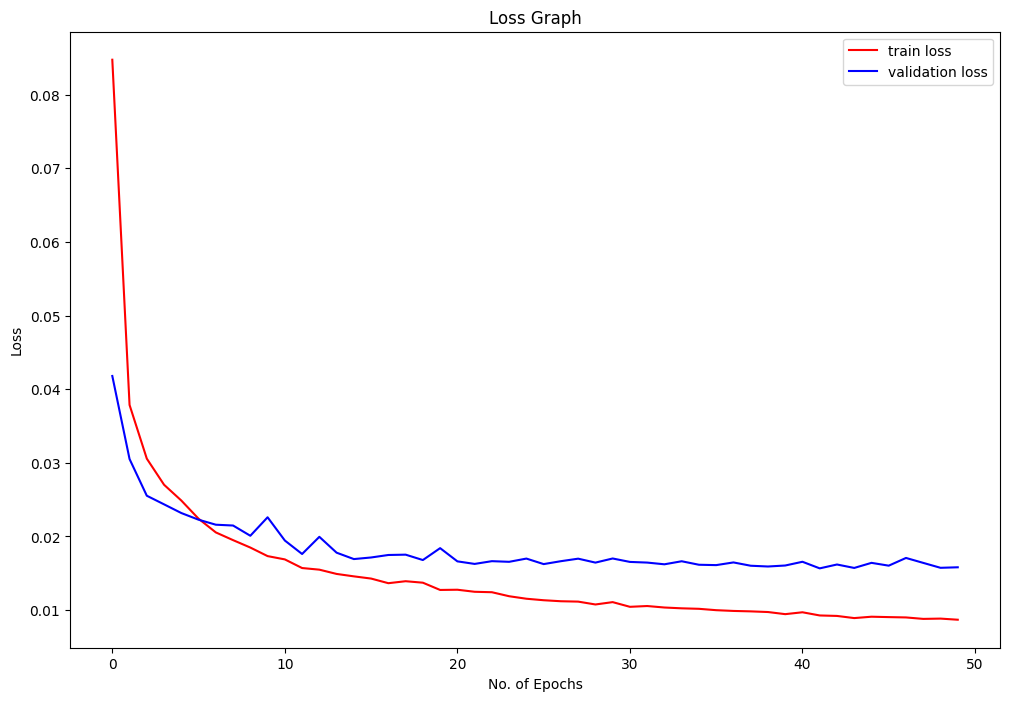

In [13]:
# Plot the loss graph

plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();


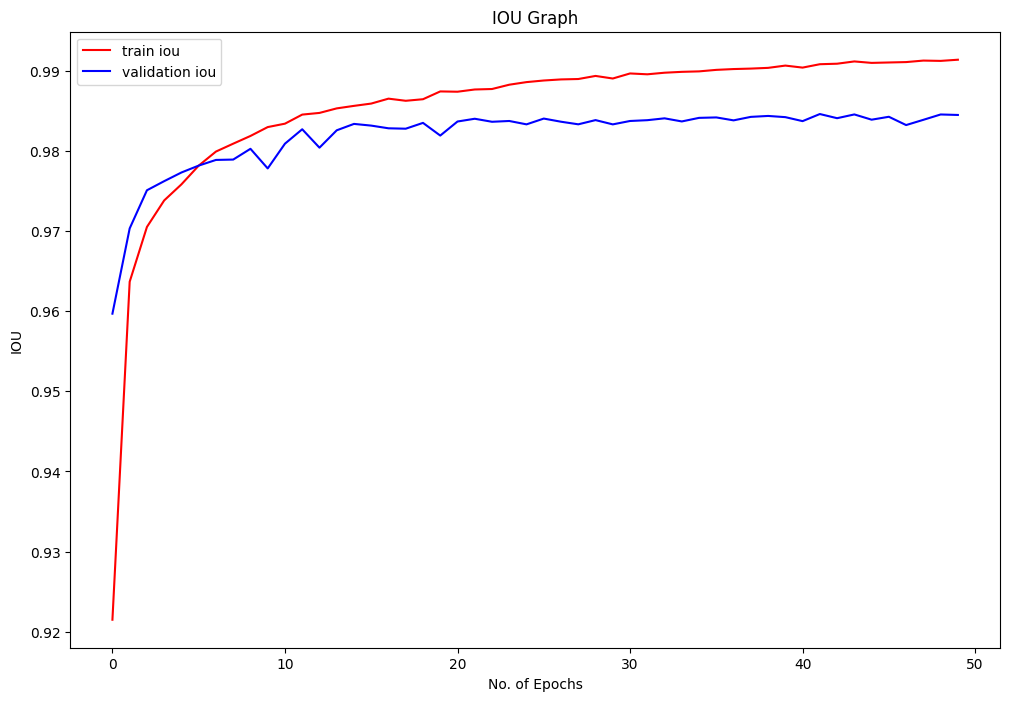

In [14]:
# Plot the IoU graph (accuracy metric)

plt.figure(figsize=(12,8))
plt.plot(r.history['iou_metric'],'r',label='train iou')
plt.plot(r.history['val_iou_metric'],'b',label='validation iou')
plt.xlabel('No. of Epochs')
plt.ylabel('IOU')
plt.title('IOU Graph')
plt.legend();


In [15]:
# Load the saved best model weights
model.load_weights('gdrive/MyDrive/Model/license_plate_detector_best_model.h5')

# Test the model
loss, iou = model.evaluate(x = my_testing_batch_generator, verbose = 1)
print("Test Loss:", loss)
print("Test IOU:", iou)


34/34 [==============================] - 13s 371ms/step - loss: 0.0162 - iou_metric: 0.9841
Test Loss: 0.01621180959045887
Test IOU: 0.984091579914093


In [16]:
y_cnn = model.predict(x = my_testing_batch_generator, verbose = 1)

34/34 [==============================] - 11s 327ms/step


In [17]:
# Show test results - images with predicted bounding box

#plt.figure(figsize=(20,40))  #figsize = (width, height) in inches
plt.figure(figsize=(17,20))  #figsize = (width, height) in inches
# Print results of 20 images each time. Image index (start,end)=(0,20), (20,40), (60,80), ...
start_index = 320
stop_index = 340
for i in range(start_index, stop_index) :
    plt.subplot(4,5,i+1-start_index)  # (row, column, index=1,2,3,...,row*column)
    plt.axis('off')

    # Load test images
    img = cv2.imread('/content/all_images/' + X_test_filenames[i])
    h,w,d = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2.imread image format is BGR, need to convert to RGB
    #img = cv2.resize(img,(224,224))   # cv2.resize(img, (width, height))

    # Un-normalised bounding box co-ordinates
    #ny = y_cnn[i]*224.
    ny = y_cnn[i]
    ny[0] = ny[0]*w
    ny[1] = ny[1]*h
    ny[2] = ny[2]*w
    ny[3] = ny[3]*h

    # Draw bounding box on test images with ny[0]=xmin, ny[1]=ymin, ny[2]=xmax, ny[3]=ymax
    image = cv2.rectangle(img,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),color=(0, 255, 0),thickness=2)
    plt.imshow(image)

Output hidden; open in https://colab.research.google.com to view.